In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Template 02
- multi-class - Fashion MNIST dataset (all 60000 images)

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score)



# from utils.helper import fn_plot_confusion_matrix

In [3]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
# # Some basic parameters
# inpDir = '../../../input' # location where input data is stored
# outDir = '../output' # location to store outputs
# subDir = 'fashion_MNIST' # location of the images
# modelDir = '../models'
altName = 'base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # for reproducibility
tf.random.set_seed(RANDOM_STATE) # for reproducibility
BATCH_SIZE = 32 #  batch size for training

EPOCHS = 500 # number of cycles to run
ALPHA = 0.001 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

### Helper Functions

In [5]:
def fn_plot_labels(train_df : pd.DataFrame,
                   test_df : pd.DataFrame):
    
    '''
    Args:
        train_df (pd.DataFrame) : Train Set
        test_df (pd.DataFrame) : Test Set
    '''
    
    plt.figure (figsize=(15,4))
    
    plt.subplot(1,2,1)
    
    ax = train_df['label'].value_counts().plot(kind='bar', alpha=0.6,color = 'DarkBlue', title='Train')
    
    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar', alpha=0.6,color = 'Orange', title='Test')

In [6]:
# fn_plot_labels(train_df=train_df, test_df=test_df)

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [7]:
# train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
# test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv('fashion-mnist_train.csv', header = 0)
test_df = pd.read_csv('fashion-mnist_test.csv', header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [8]:
train_df[:10000].shape

(10000, 785)

In [9]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [10]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

Each label is an integer between 0 and 9:

In [12]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

## Whats in the data?

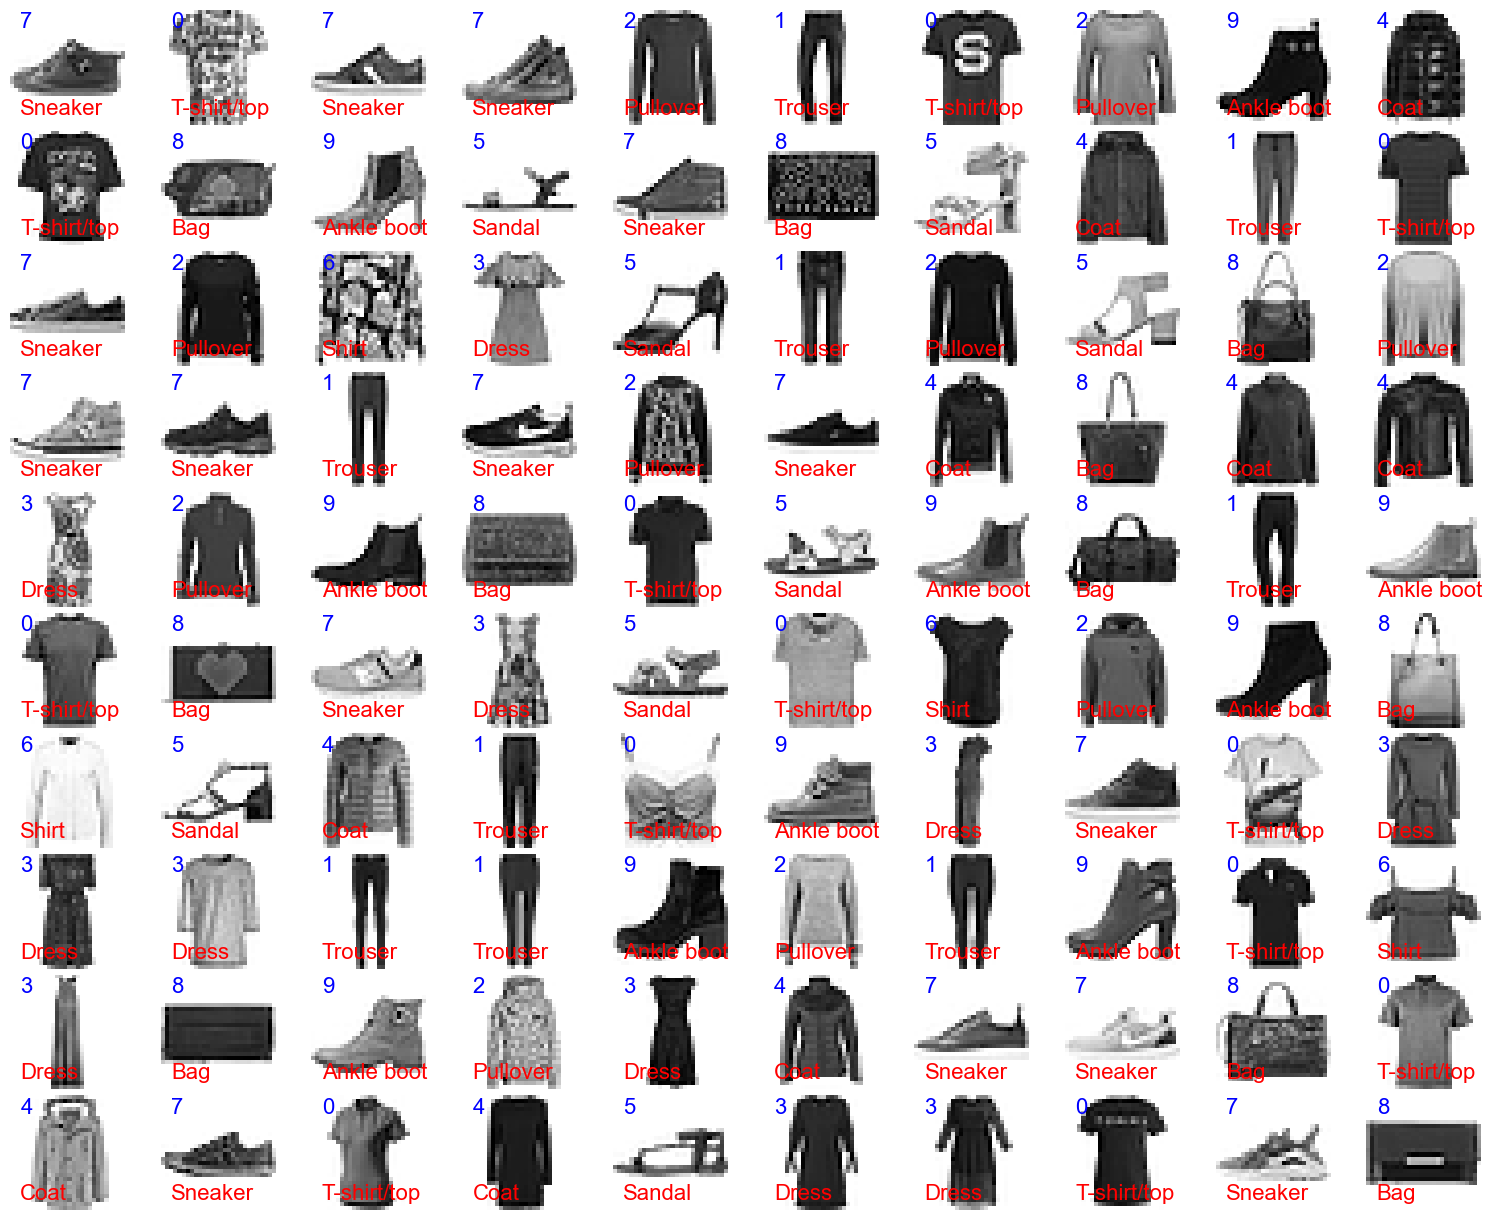

In [13]:
# Sample data plot

plot_df = train_df.sample(n = 100) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 12))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(10, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=16)   # add number (class) of the image
    
    ax.text(2, 25, class_names[row.iloc[0]], color='r', fontsize=16)   # add name of the image
    
plt.show()

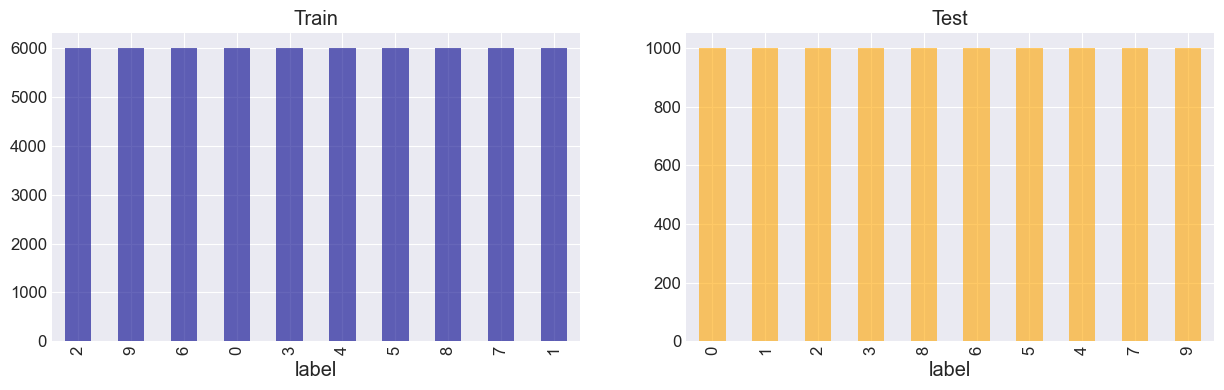

In [14]:
fn_plot_labels(train_df=train_df, test_df=test_df)

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [15]:
def fn_split_feature_label(row):
    
    feature = tf.reshape(row[1:], [28, 28, 1]) # reshape to 28x28x1
    label = row[0] # label is the first column
    return feature, label


# X_train = train_df.drop('label', axis = 1).to_numpy()
# y_train = train_df['label'].to_numpy()

# X_test = test_df.drop('label', axis = 1).to_numpy()
# y_test = test_df['label'].to_numpy()

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [16]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df) # create a tensorflow dataset from the pandas dataframe
train_ds = tmp_ds.map(fn_split_feature_label) # map the function to the dataset to split feature and label
train_ds = train_ds.batch(BATCH_SIZE) # get me only one batch of data

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df) # create a tensorflow dataset from the pandas dataframe
test_ds = tmp_ds.map(fn_split_feature_label) # map the function to the dataset to split feature and label
test_ds = test_ds.batch(BATCH_SIZE) # get me only one batch of data

In [17]:
# X_train = X_train / 255.0

# X_test = X_test / 255.0

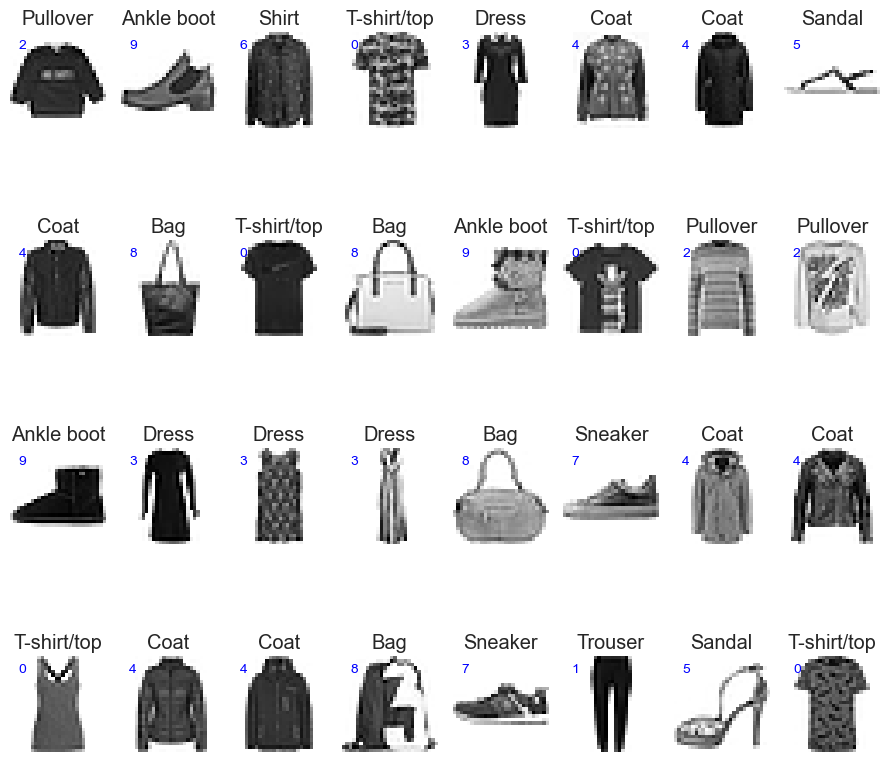

In [18]:
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        plt.axis('off')
        plt.title(class_names[labels[i].numpy()])
        plt.text(2, 4, labels[i].numpy(), color='b')
    plt.tight_layout()
    plt.show()

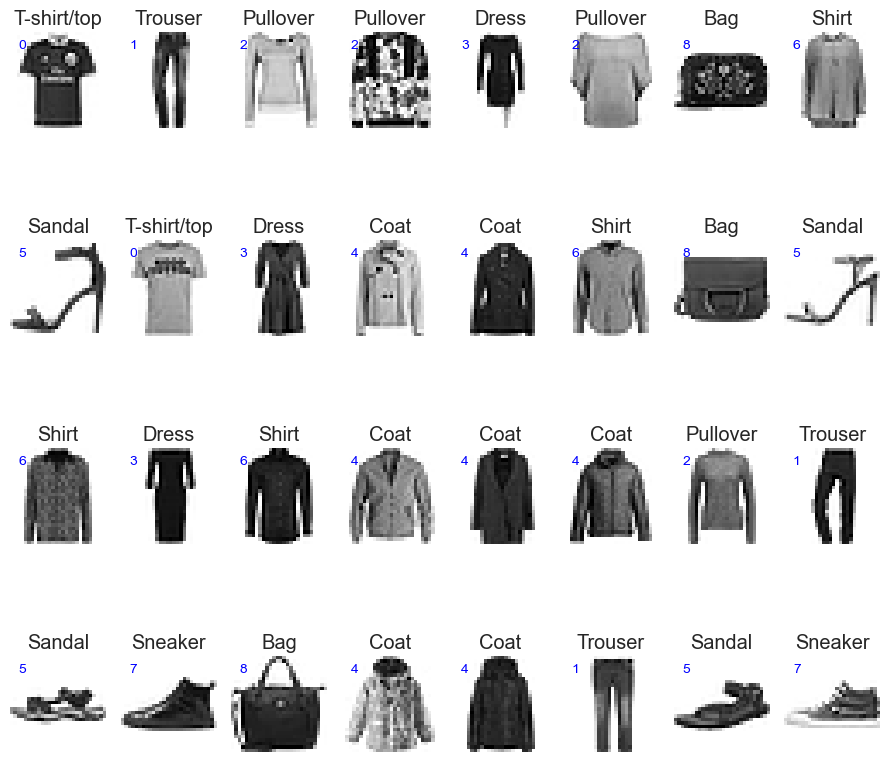

In [19]:
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        plt.axis('off')
        plt.title(class_names[labels[i].numpy()])
        plt.text(2, 4, labels[i].numpy(), color='b')
    plt.tight_layout()
    plt.show()

## Rescaling

In [20]:
norm_layer = tf.keras.layers.Rescaling(1./255) # create a rescaling layer

image_batch, labels_batch = next(iter(train_ds)) # before rescaling

display(image_batch[0].numpy().max()) # whats max value

norm_ds = train_ds.map(lambda x, y: (norm_layer(x), y)) # normalise using rescaling

image_batch, labels_batch = next(iter(norm_ds)) # whats the max value
display(image_batch[0].numpy().max()) # whats max value

255

1.0

In [21]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE) # cache and prefetch the data
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Demo

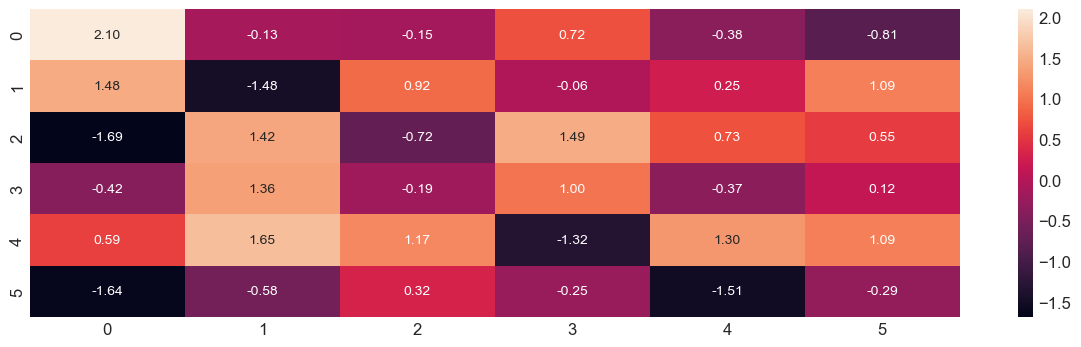

In [22]:
import seaborn as sns
plt.figure(figsize=(15,4))

input_shape = (1,6,6,1)
X = tf.random.normal(input_shape)
X.shape
sns.heatmap(X.numpy()[0,:,:,0], annot=True, fmt=".2f");

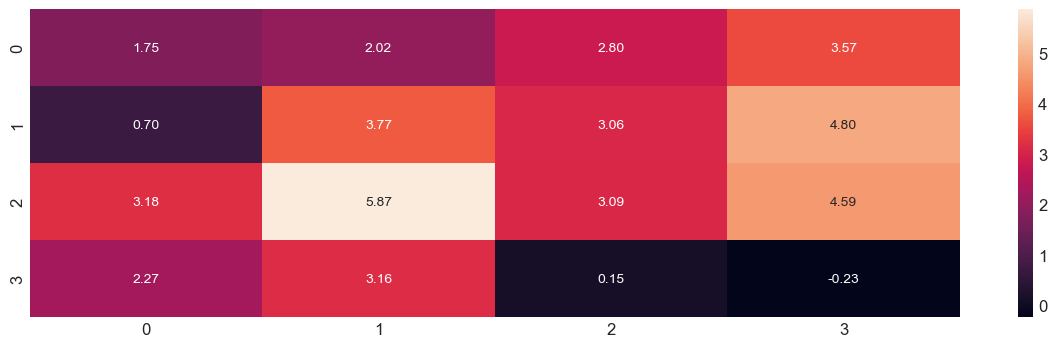

In [23]:
plt.figure(figsize=(15,4))
y = tf.keras.layers.Conv2D(1, 3, kernel_initializer=tf.constant_initializer(1.),
                           use_bias=False)(X)
sns.heatmap(y.numpy()[0,:,:,0], annot=True, fmt=".2f");

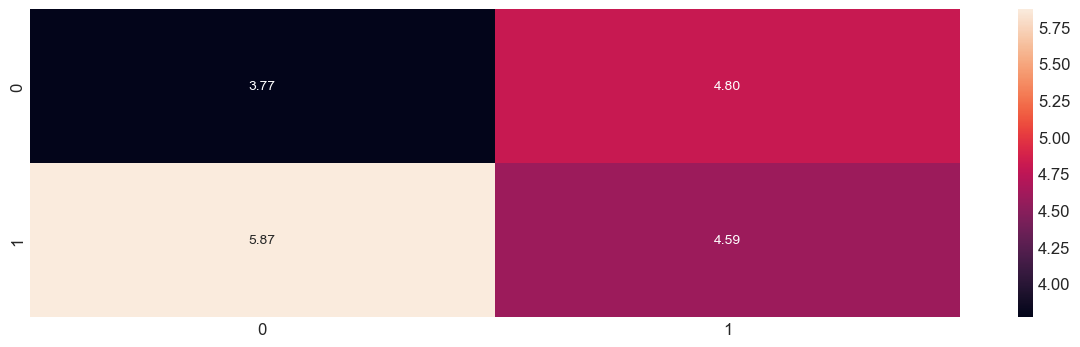

In [24]:
plt.figure(figsize=(15,4))
max_pool = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(y)
sns.heatmap(max_pool.numpy()[0,:,:,0], annot=True, fmt=".2f");

In [25]:
input_shape = (28, 28, 1)
knl_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE) # kernel initializer
# Reg 1 : L2 regularization
# knl_reg = tf.keras.regularizers.L2(l2 = 0.005) # kernel regularizer
# Reg 2 : Batch norm + Dropout
dor1 = 0.3
dor2 = 0.3
dor3 = 0.3
dor4 = 0.3

model = tf.keras.Sequential(name= 'MNIST_Fashion') # instantiate the model

model.add(tf.keras.Input(shape=(input_shape), name='Input')) # input layer
model.add(tf.keras.layers.Rescaling(1./255.)) # rescale the image

### Set 1
model.add(tf.keras.layers.Conv2D(32, (3,3), name='Conv1', kernel_initializer=knl_init, padding='same')) # first convolutional layer 28 x 28 x 32
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU(name='ReLU1'))
model.add(tf.keras.layers.Dropout(dor1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')) # max pooling layer 14 x 14 x 32

### Set 2
model.add(tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=knl_init)) # second convolutional layer 12 x 12 x 64
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU(name='ReLU2'))
model.add(tf.keras.layers.Dropout(dor2))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')) # max pooling layer 6 x 6 x 64

### Set 3
model.add(tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=knl_init)) # third convolutional layer 4 x 4 x 128
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU(name='ReLU3'))
model.add(tf.keras.layers.Dropout(dor3))
### Head 
model.add(tf.keras.layers.Flatten()) # 2048

### Dense 1
model.add(tf.keras.layers.Dense(128, kernel_initializer=knl_init))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(dor4))
### Dense 2
model.add(tf.keras.layers.Dense(10))

model.summary()


Model: "MNIST_Fashion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU1 (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU2 (ReLU)                    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU3 (ReLU)                    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,642 (1.36 MB)

 Trainable params: 356,938 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
filepath = 'lstm.keras'
PATIENCE = 15
LR_FACTOR = 0.5
LR_PATIENCE = 5

mcb = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

escb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1,
    min_lr=1e-6
    )

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_ds, callbacks=[mcb, escb, lrcb], validation_data=test_ds, 
                    epochs=EPOCHS)

Epoch 1/500


1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7909 - loss: 0.5882

In [28]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.800750,0.821092,0.8480,0.625891,0.001
1,0.844917,0.602445,0.8584,0.565300,0.001
2,0.855583,0.559530,0.8591,0.538245,0.001
3,0.861817,0.535962,0.8598,0.528173,0.001
4,0.865167,0.518730,0.8630,0.513818,0.001


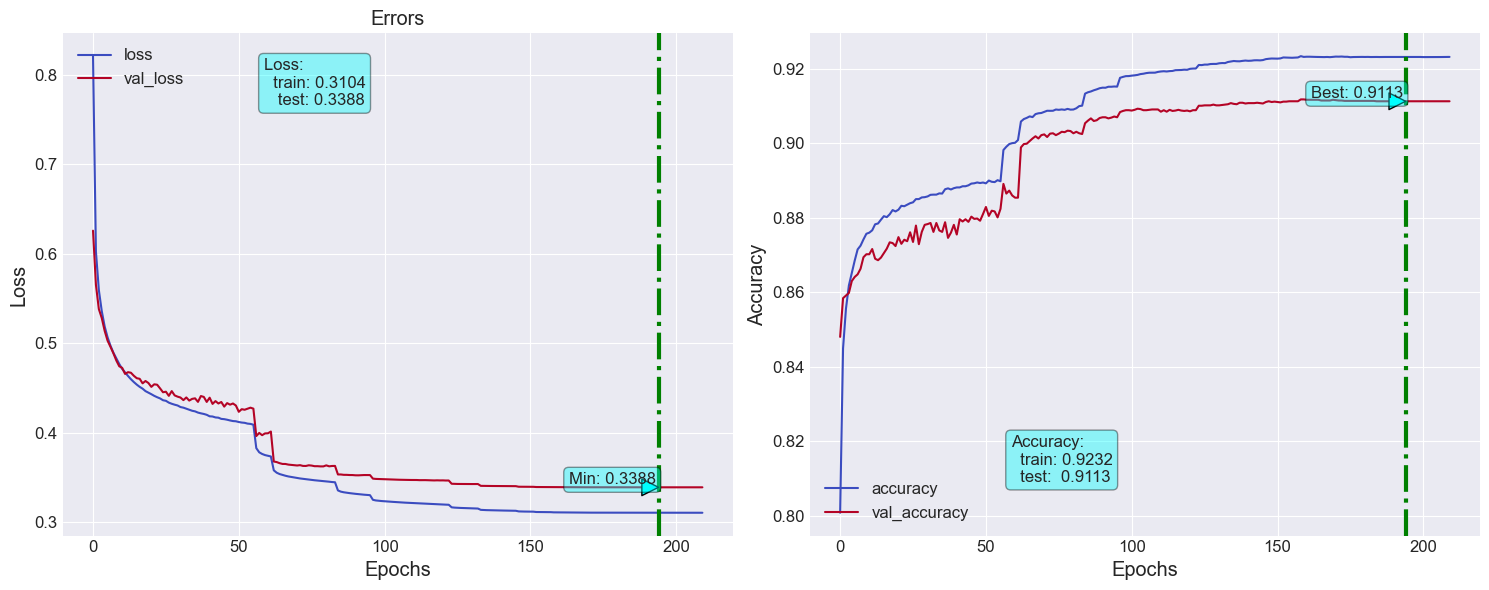

In [29]:
fn_plot_tf_hist(loss_df)

In [ ]:
# extract test labels from the test dataset
y_test = tf.concat([y for x,y in test_ds], axis = 0).numpy()

# make predictions (output is logits)
yhat = model.predict(test_ds)
# create predictions
y_pred = yhat.argmax(axis=1)
y_pred.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(10000,)

In [31]:
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')

Accuracy: 0.9113


In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.88      0.85      0.86      1000
           3       0.92      0.92      0.92      1000
           4       0.87      0.88      0.87      1000
           5       0.99      0.97      0.98      1000
           6       0.75      0.73      0.74      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



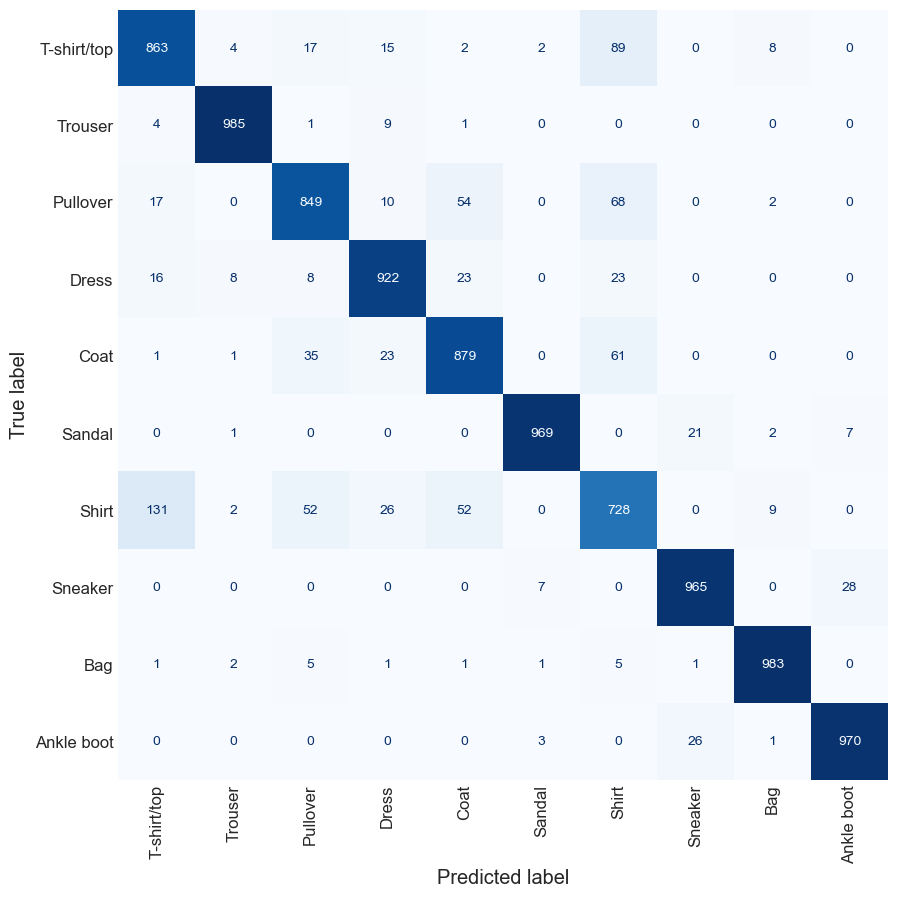

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names.values())

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax= ax, cmap='Blues', xticks_rotation='vertical',colorbar=False)        
plt.grid(False)
plt.show()                                                                                         

In [34]:
print(f'F1_score: {f1_score(y_true=y_test, y_pred=y_pred, average='weighted'):.4f}')

F1_score: 0.9111
